In [1]:
from utils.Auger.SD.Monitoring import Monit
from scipy.optimize import curve_fit
from utils.binaries import *
from utils import CONSTANTS
import os

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, t=None, version=None):
     
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC_bin_edges = np.array([4*k for k in range(100)] + [400 + 16*k for k in range(51)])
        case 3:
            ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
    ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])

    skip = 5
    _peak = np.argmax(counts[skip:100]) + skip
    _dip = np.argmax(np.diff(counts)) + 3
    start, stop = _dip + int(0.5 * (_peak - _dip)), _peak + int(0.5*(_peak - _dip))

    try:
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop],
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, ADC[_peak], counts[_peak]])
        if t is not None:
            fig = plt.figure()
            plt.plot(ADC, counts)
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height))
            plot.save(fig, f'DaqIntegrationTest/{version}/pmt{int(p)}/{t}.png')
            plt.close(fig)

        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError
    except ValueError: 
        return np.nan, np.nan
    except LinAlgError:
        return np.nan, np.inf

    return mip.n, mip.std_dev


version = 'v20'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

monit = Monit(*monit_files)
t, wcd = monit('fTime', 136), monit('fPeak', 136).T
vem = np.array([np.mean(w) for w in wcd] + [50])

data = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/out.txt')


09:25:25 (  +61.3s) [INFO   ] -- import logging
09:25:25 (    +3ms) [INFO   ] -- import numpy as np
09:25:25 (    +7ms) [INFO   ] -- import uncertainties
09:25:25 (    +3ms) [INFO   ] -- import numpy as np
09:25:25 (    +7ms) [INFO   ] -- import uncertainties
09:25:25 (  +449ms) [INFO   ] -- import pandas as pd
09:25:25 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
09:25:25 (    +2ms) [INFO   ] -- import binaries.tools as tools
09:25:26 (  +369ms) [INFO   ] -- received 1 file(s) as input
09:25:26 (  +121ms) [INFO   ] -- View monit keys with self.keys()
09:25:26 (  +119ms) [INFO   ] -- found 209 entries for key fTime and station #136
09:25:26 (    +6ms) [INFO   ] -- found 209 entries for key fPeak and station #136


09:25:30 (   +3.6s) [INFO   ] -- import matplotlib.pyplot as plt
09:25:30 (  +251ms) [INFO   ] -- import seaborn as so
09:25:30 (    +2ms) [INFO   ] -- import plotting.tools as plot
09:25:30 (   +11ms) [DEBUG  ] -- font size set to 9.5
09:25:30 (    +1ms) [DEBUG  ] -- label size set to 13.0
09:25:30 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
09:25:30 (    +1ms) [DEBUG  ] -- markersize set to 2.0
09:25:30 (    +1ms) [DEBUG  ] -- usetex set to False


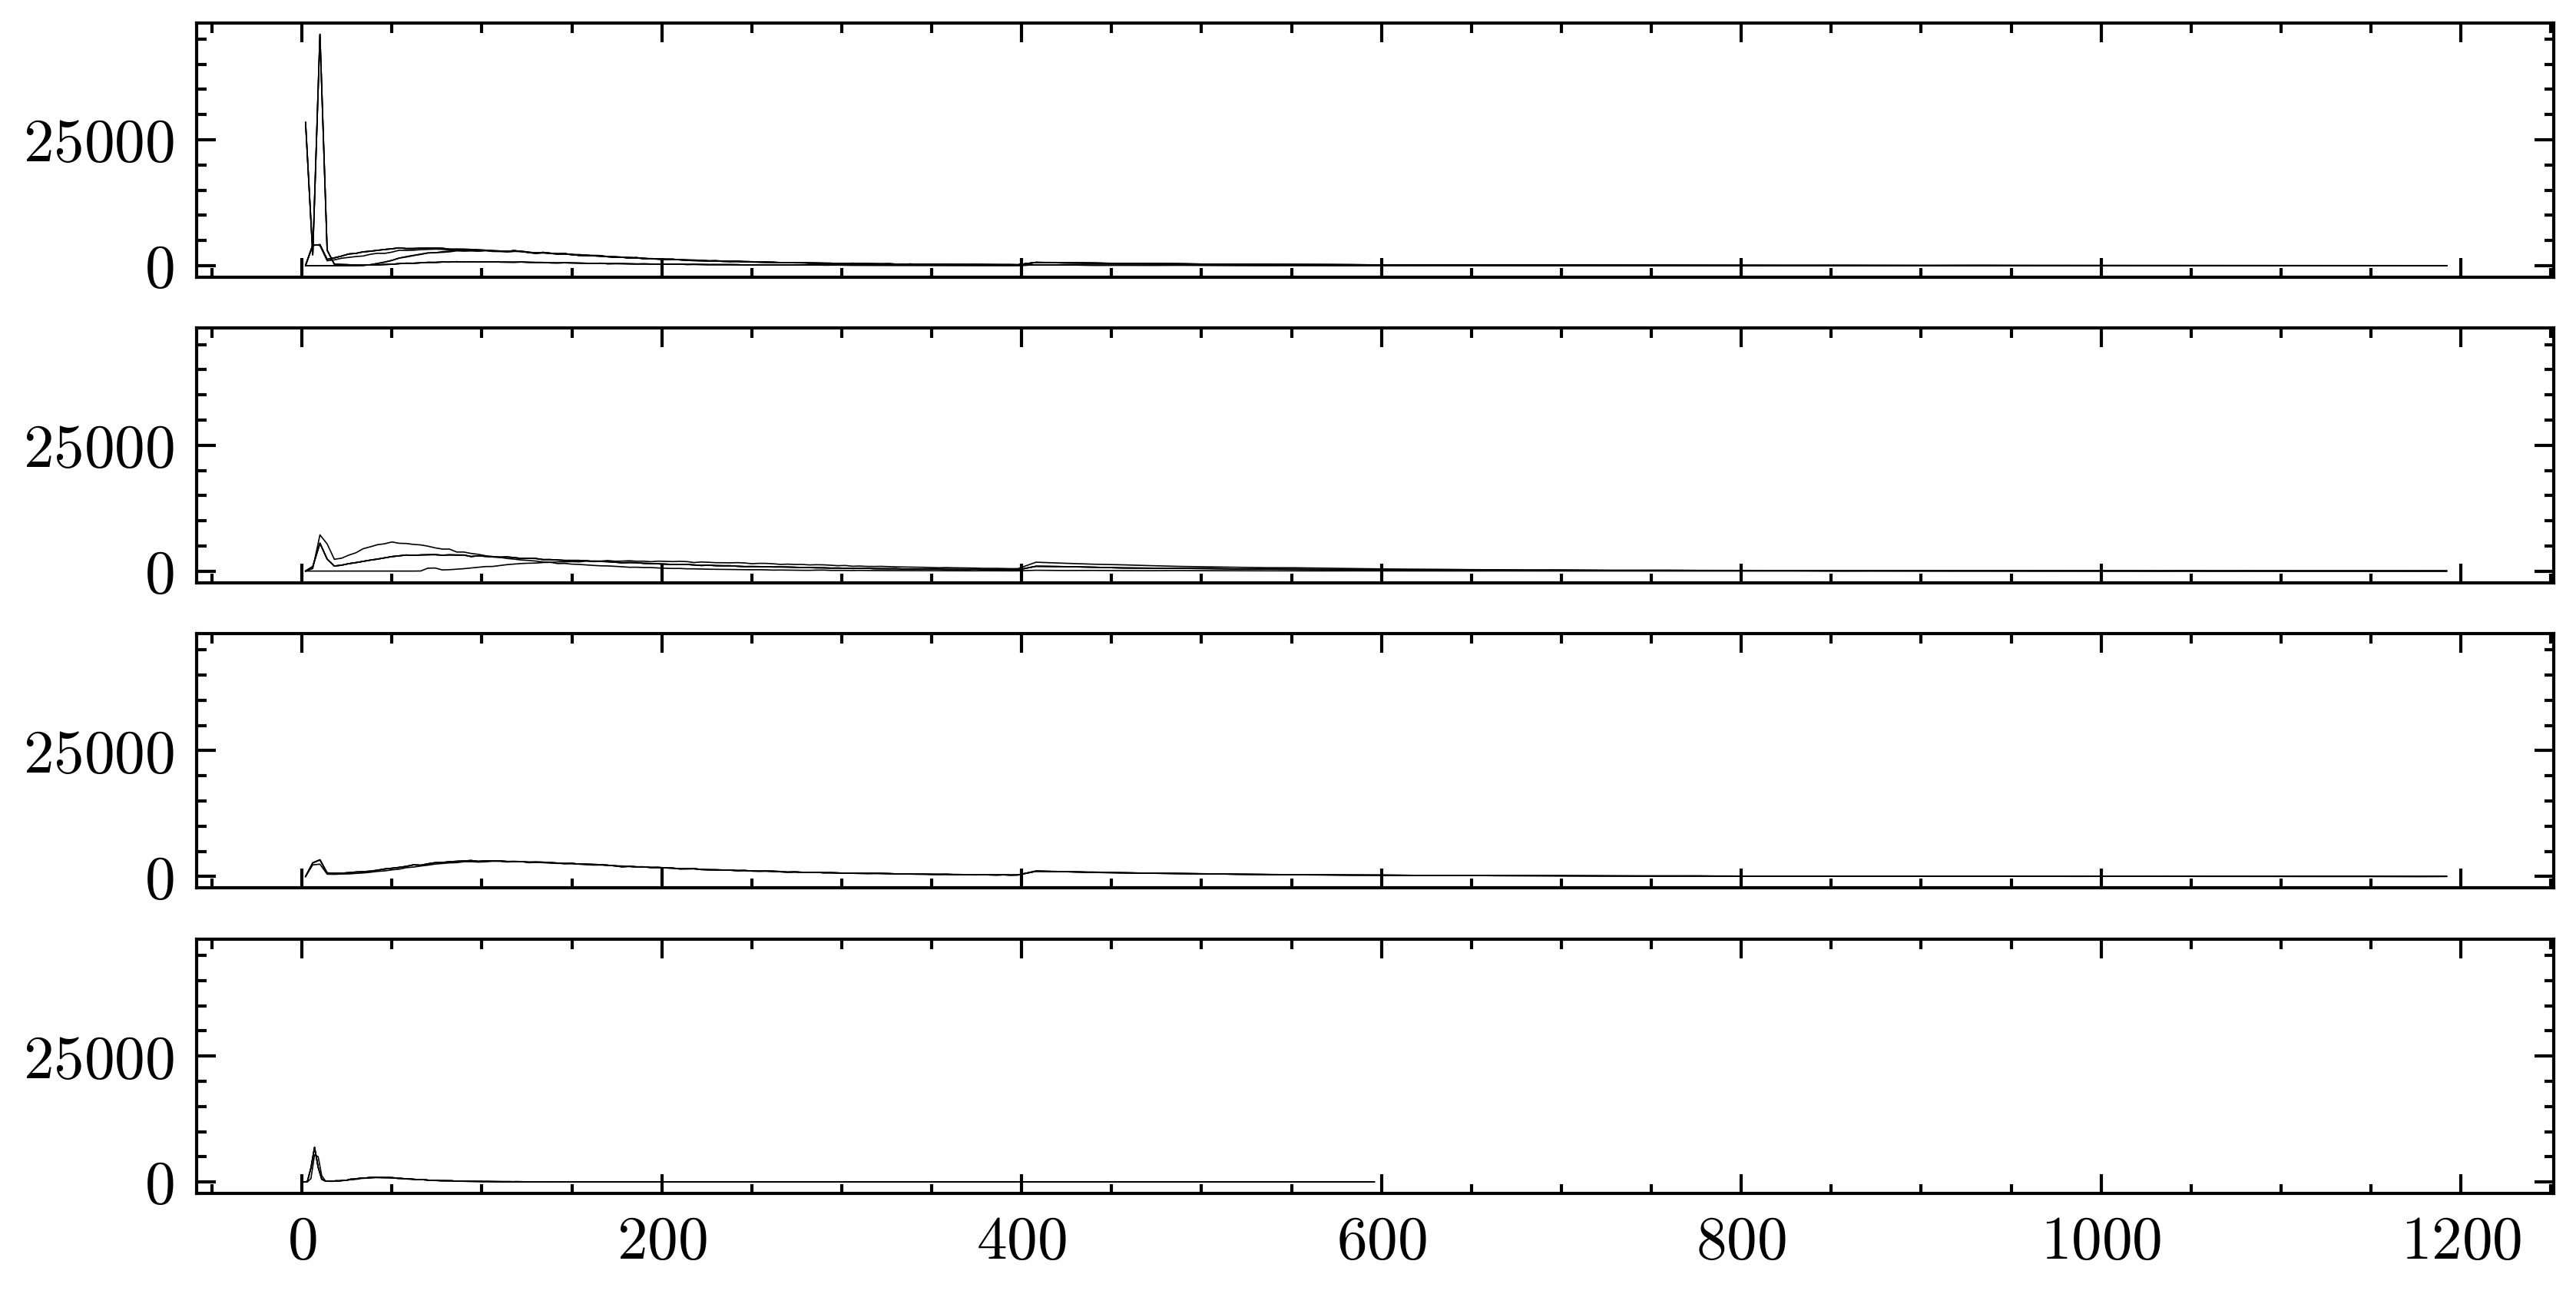

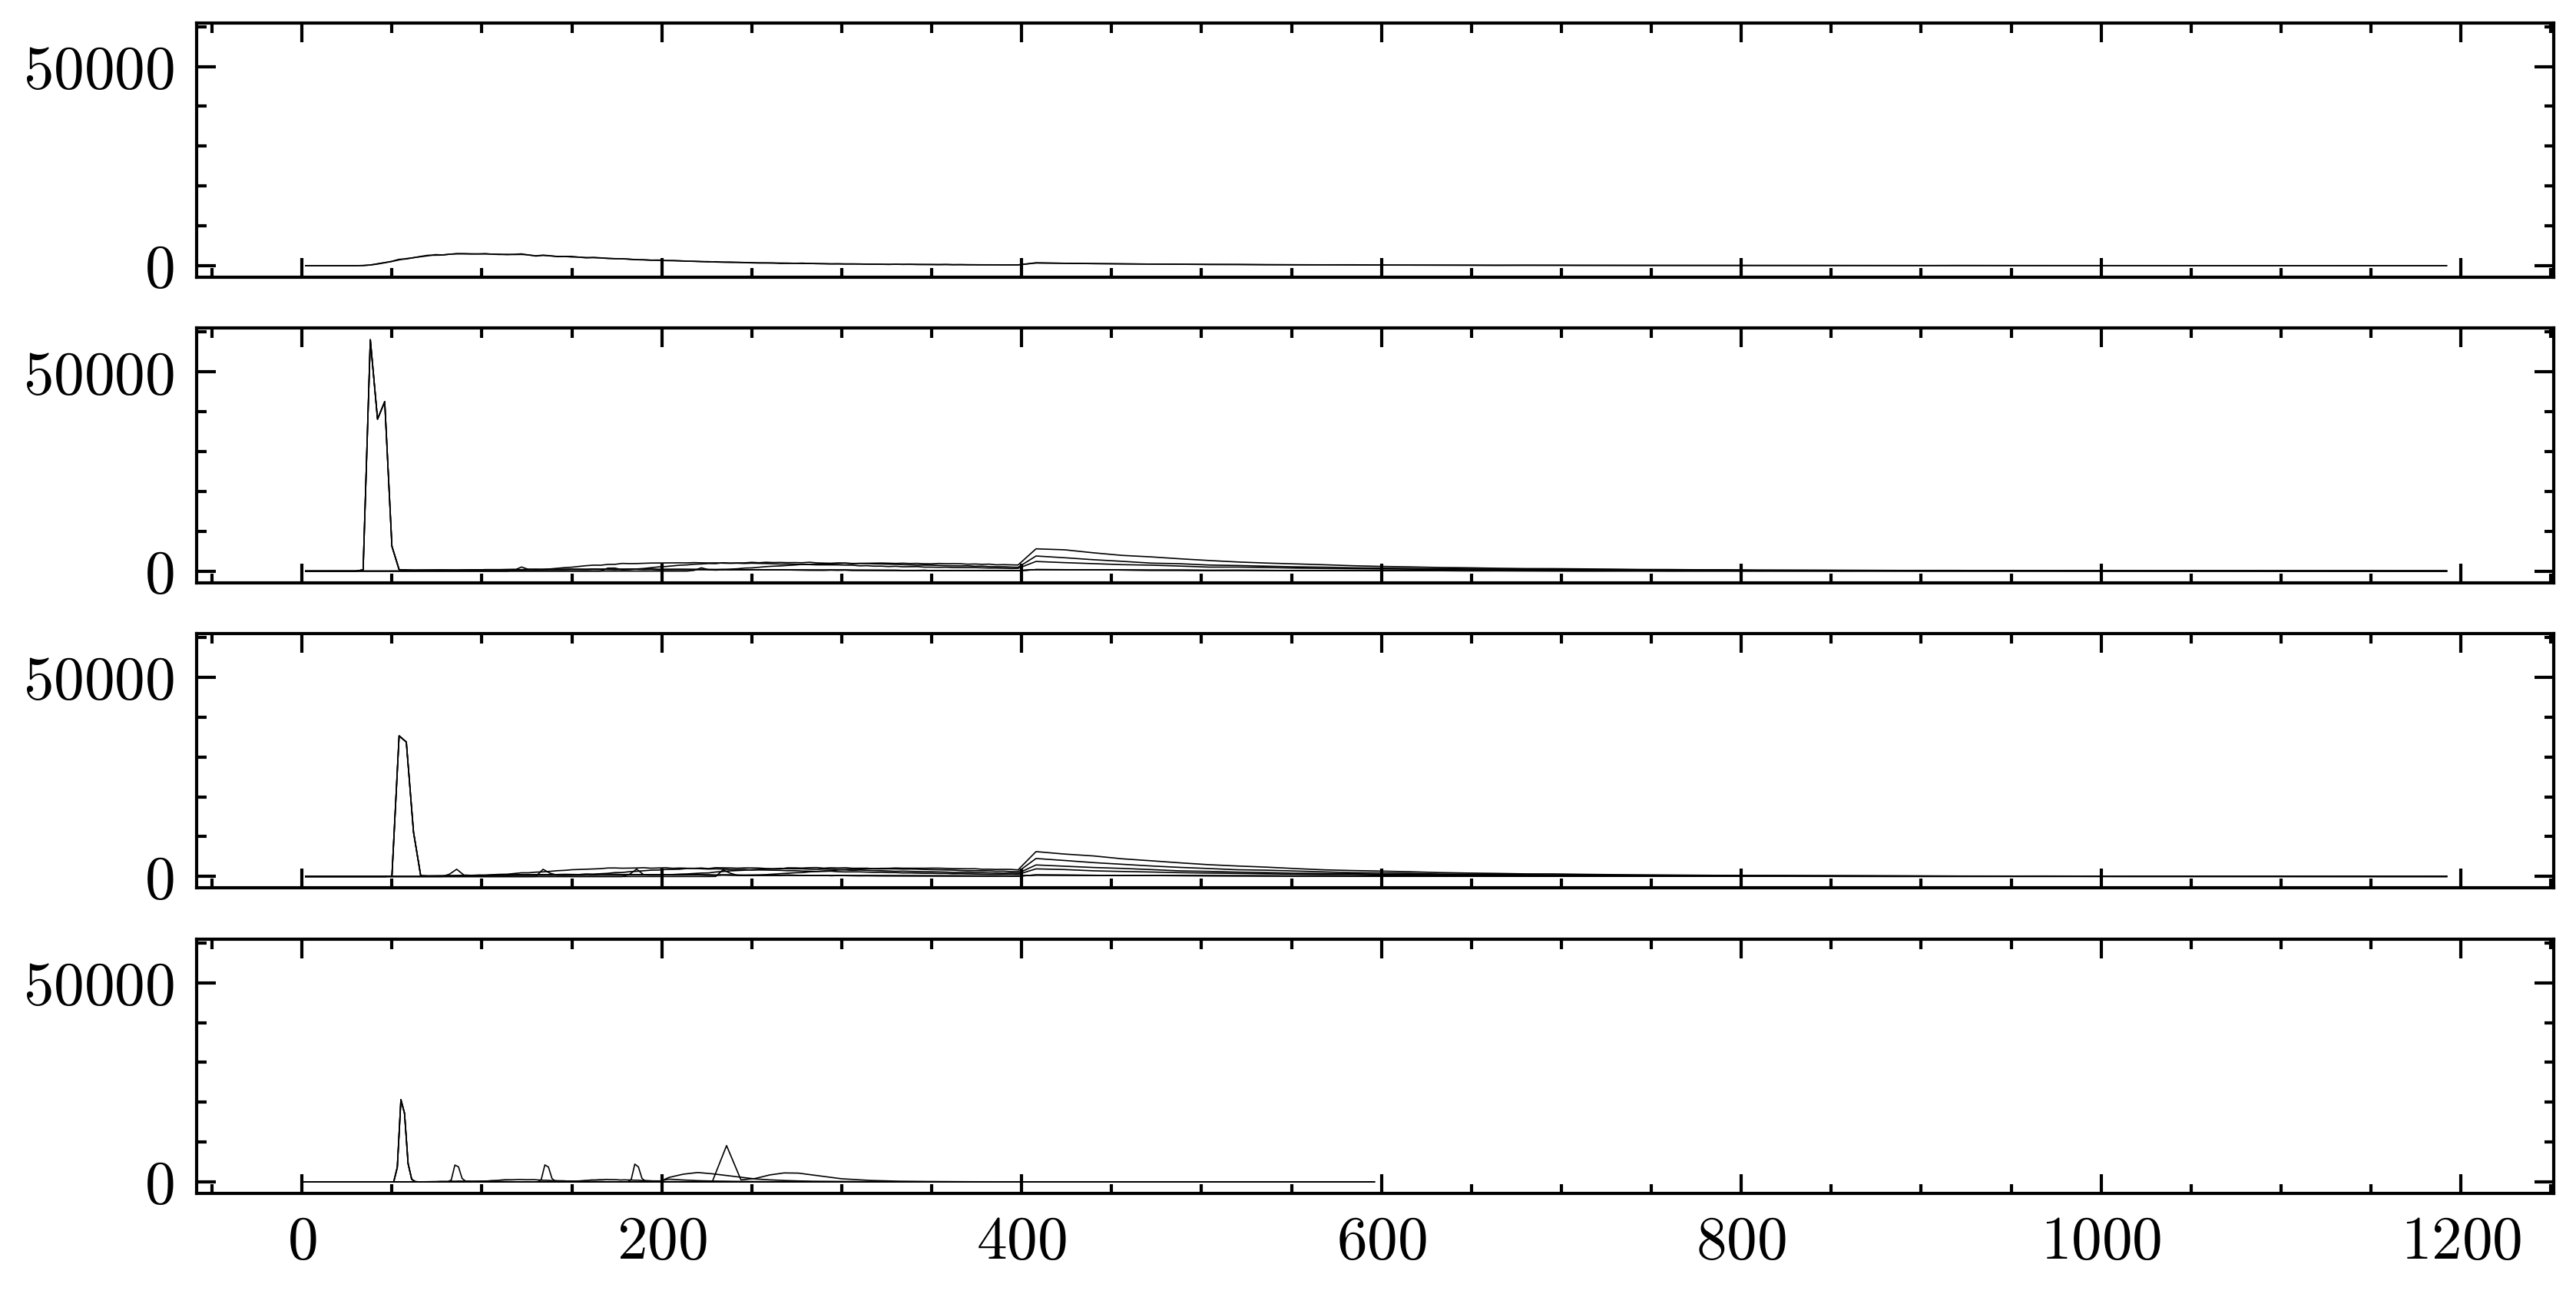

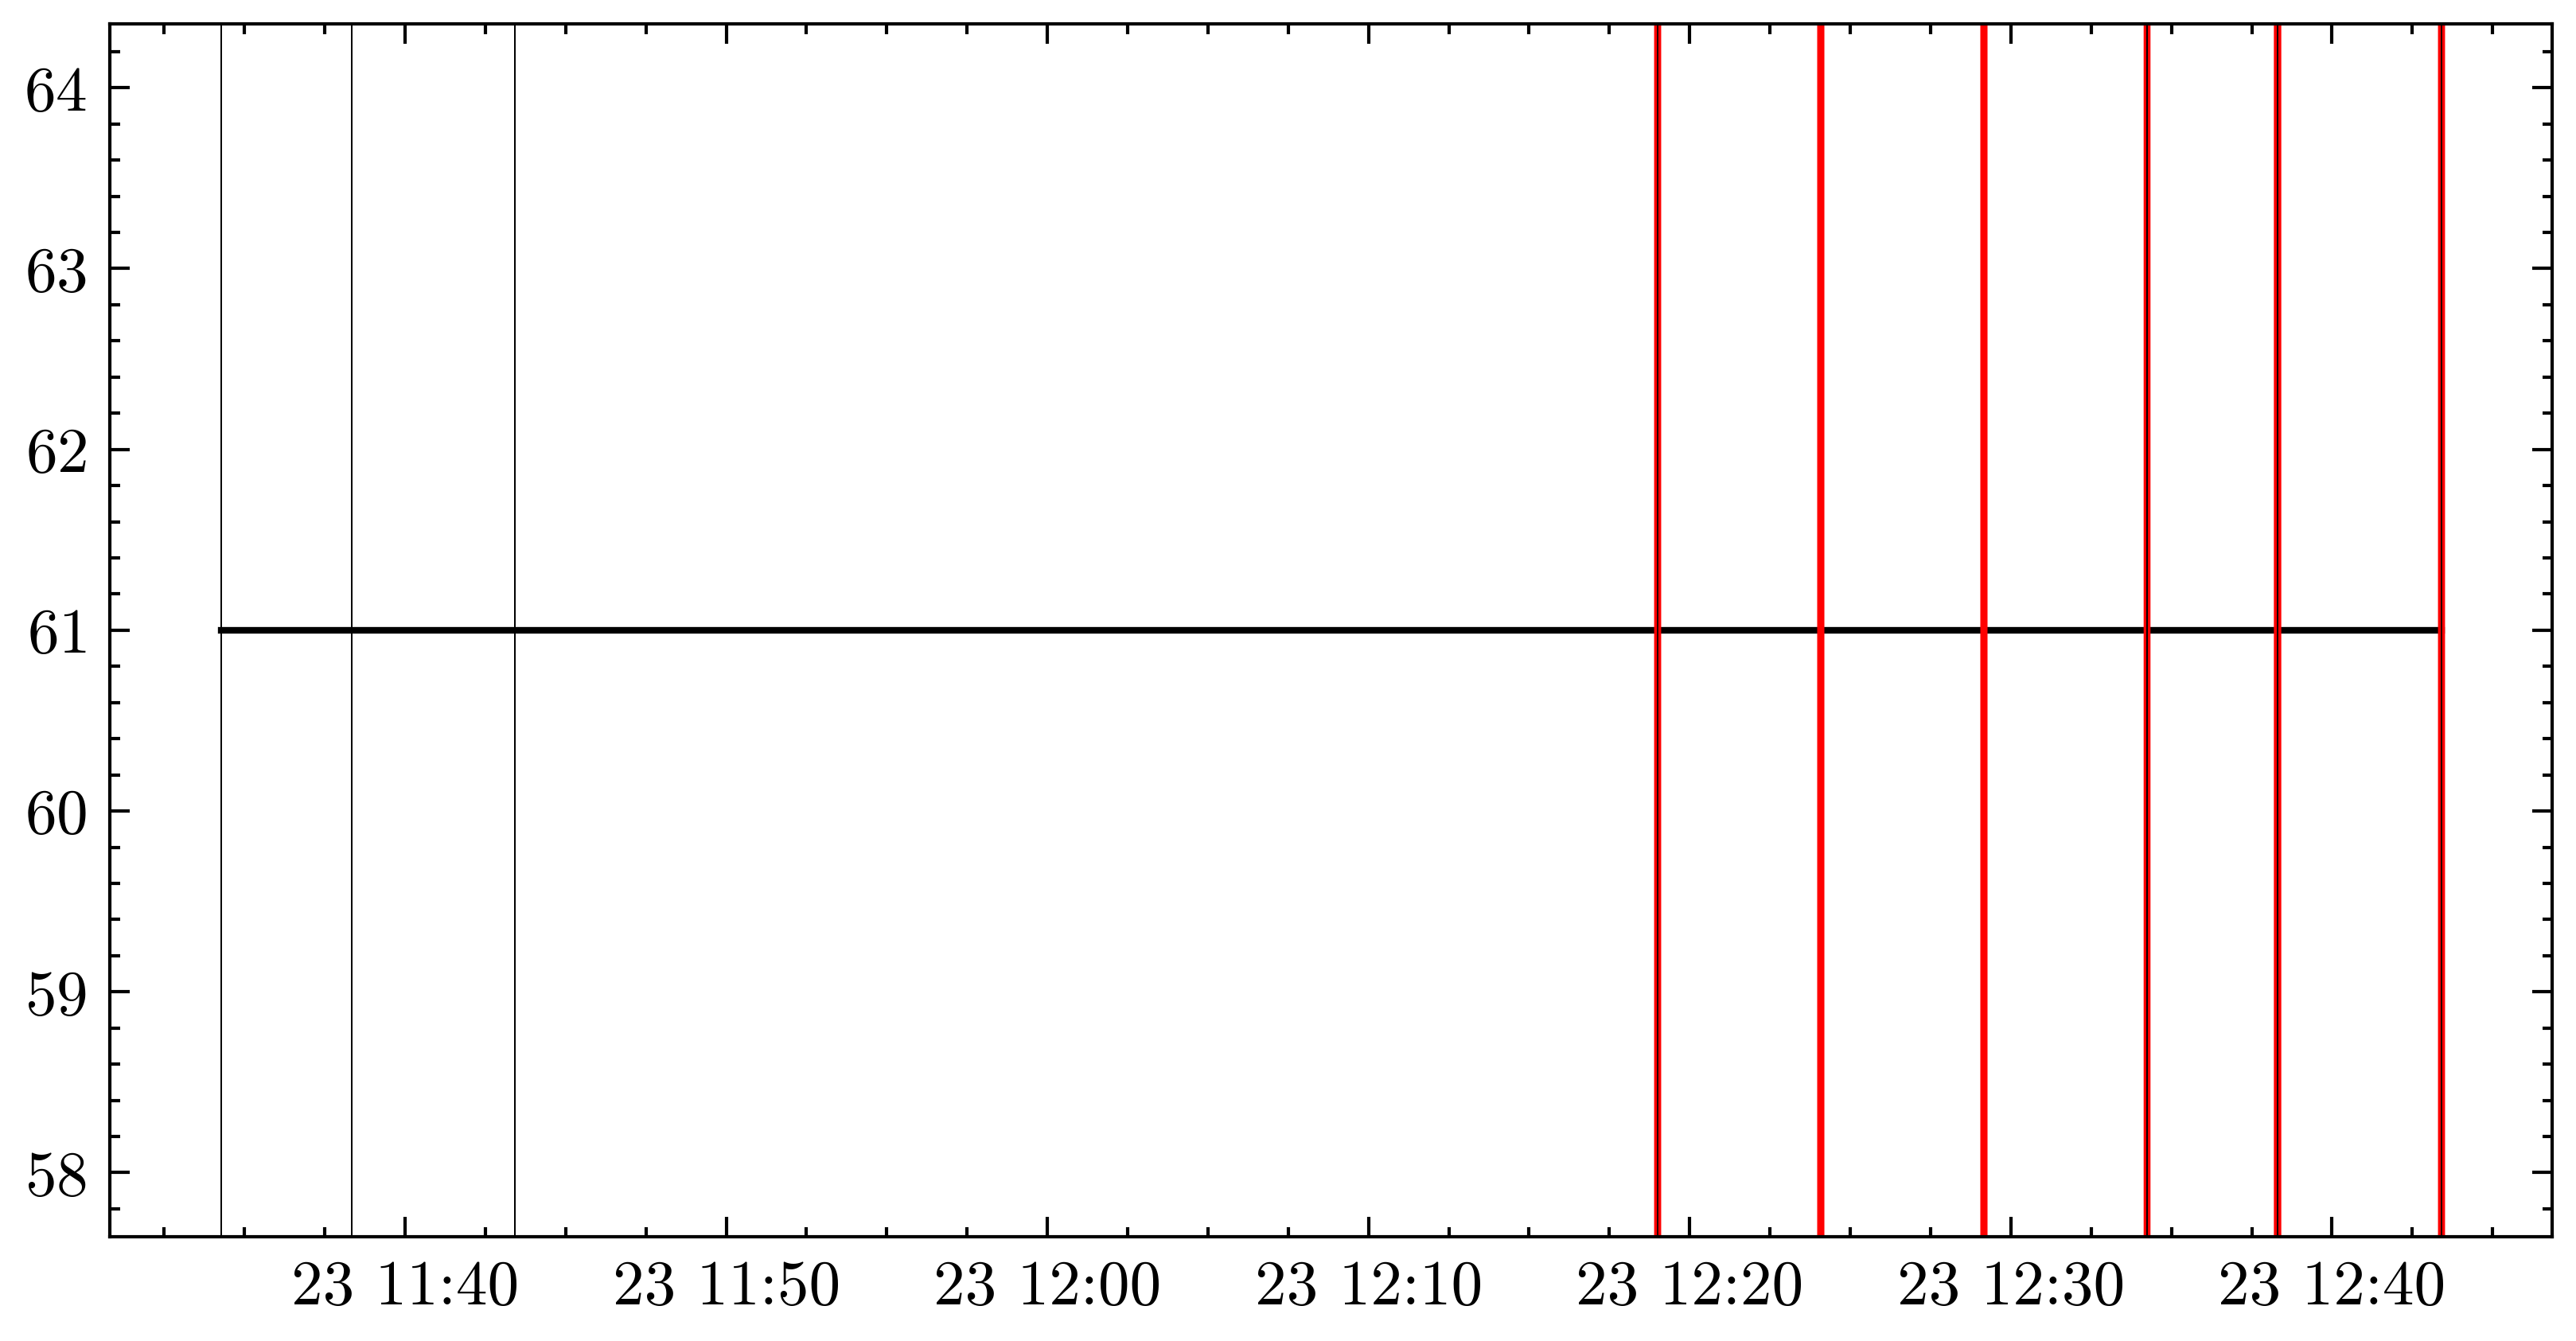

In [2]:
from utils.plotting import *
_, axes_good = plt.subplots(nrows=4, sharey=True, sharex=True)
_, axes_fail = plt.subplots(nrows=4, sharey=True, sharex=True)
_ = plt.figure()

t_acq, t_gps = data[:, 1], data[:, 2]
plt.plot(plot.to_datetime(t_gps), t_acq)

offsets = [[] for _ in range(4)]
for event in data:
    _, t_acq, t, pmt, *histo = event
    histo = np.array(histo)
    
    if not np.sum(histo[:5]):
        bins = CONSTANTS.UUB_SSD_BIN_CENTERS if pmt == 3 else CONSTANTS.UUB_WCD_BIN_CENTERS
        axes_fail[int(pmt)].plot(bins, histo, c='k', lw=0.2, ls='solid')
        plt.axvline(plot.to_datetime(t), c='r', ls='solid')
        offsets[int(pmt)].append((histo != 0).argmax())
    else:
        bins = CONSTANTS.UUB_SSD_BIN_CENTERS if pmt == 3 else CONSTANTS.UUB_WCD_BIN_CENTERS
        axes_good[int(pmt)].plot(bins, histo, c='k', lw=0.2, ls='solid')
        plt.axvline(plot.to_datetime(t), c='k', ls='solid', lw=0.2, zorder=10)
         